In [61]:
######################################################## CONSTANTS ########################################################
import CONSTANTS as c

NR_OF_BINS = c.NR_OF_BINS
INTERPLOATION_POINTS = c.INTERPLOATION_POINTS
FFT_AC_COEFFICIENT  = c.FFT_AC_COEFFICIENT
LOWER_POINT = c.LOWER_POINT
UPPER_POINT = c.UPPER_POINT
THRESHOLD = c.THRESHOLD
PREPROCESSED_DATA_PATH = c.PREPROCESSED_DATA_PATH
FEATURE_ENGINEERED_DATA_PATH = c.FEATURE_ENGINEERED_DATA_PATH

######################################################## LIBRARIES ########################################################
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler

import os

i = 0
for oFile in os.walk(PREPROCESSED_DATA_PATH):
    sFolderPath = oFile[0]
    
    if sFolderPath != PREPROCESSED_DATA_PATH:
        sSubFolder = sFolderPath.split('\\')[-1]
        
        sFolderToWrite = r'{}\{}'.format(FEATURE_ENGINEERED_DATA_PATH, sSubFolder)
        
        if os.path.exists(sFolderToWrite) == False:
            os.makedirs(sFolderToWrite)
        
        if all(elem in os.listdir(sFolderToWrite)  for elem in  ['X_ORIGINAL.npy', 'X_ORIGINAL.npy', 'X_ORIGINAL.npy']) == True:
            continue

            
        ######################################################## DATA SOURCE ########################################################
        X_ORIGINAL = np.load(r'{}\X_ORIGINAL.npy'.format(sFolderPath))
        X_TIME_ORIGINAL = np.load(r'{}\X_TIME_ORIGINAL.npy'.format(sFolderPath))
        Y_ORIGINAL = np.load(r'{}\Y_ORIGINAL.npy'.format(sFolderPath))
        
        
        if i ==0:
            X = X_ORIGINAL
            Y = Y_ORIGINAL
            X_TIME = X_TIME_ORIGINAL
        else:
            X = np.concatenate([X, X_ORIGINAL])
            X_TIME = np.concatenate([X_TIME, X_TIME_ORIGINAL])
            Y = np.concatenate([Y, Y_ORIGINAL])            
        
        i = i +1
        
        if i == 3:
            break

            


X = X[:,:,:,0]
Y = Y[:,:,:,0]


# revert back to prices from change_rates
sExchangeRate = 'EURUSD'
df = pd.read_csv(r'Data\{}_M1_202010010001_202210312359.csv'.format(sExchangeRate), delimiter = '\t')
df.loc[:, 'PRICE_TIME_STAMP'] = pd.to_datetime(df['<DATE>'] + df['<TIME>'], format='%Y.%m.%d%H:%M:%S')
df.drop(['<DATE>', '<TIME>'], axis = 1, inplace = True)
df.loc[:, 'EXCHANGE_RATE'] = sExchangeRate


dfTime = pd.DataFrame(
    data = X_TIME,
    columns = ['MINUTE', 'HOUR', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'MONTH', 'YEAR'])

dfTime['TIME_STAMP'] = pd.to_datetime(
    dfTime['YEAR'].astype(str) \
    + '-' + dfTime['MONTH'].astype(str) \
    + '-' + dfTime['DAY_OF_MONTH'].astype(str) \
    + ' ' + dfTime['HOUR'].astype(str) \
    + ':' + dfTime['MINUTE'].astype(str) , 
    format='%Y-%m-%d %H:%M:%S')

dfTime = dfTime[['TIME_STAMP']]


aClosePrices = dfTime.merge(
    right = df[['PRICE_TIME_STAMP','<CLOSE>']], 
    left_on = 'TIME_STAMP',
    right_on = 'PRICE_TIME_STAMP',
    how = 'inner'
)[['<CLOSE>']].values
aClosePrices = np.expand_dims(aClosePrices, 2)


X = (X * aClosePrices) + aClosePrices
Y = (Y * aClosePrices) + aClosePrices

X = X.reshape(X.shape[0] , -1)
Y = Y.reshape(Y.shape[0] , -1)


            
######################################################## PREPROCESSING ########################################################
# # remove outliers
# X[X>UPPER_POINT] = UPPER_POINT
# X[X<LOWER_POINT] = LOWER_POINT

# Y[Y>UPPER_POINT] = UPPER_POINT
# Y[Y<LOWER_POINT] = LOWER_POINT


# XTIME consists of minute, hour, day of week, day of month, month, year
# exclude month and year.
X_TIME = X_TIME[:, :4]

# # convert cyclic features to time sinus function
# X_TIME = (2 * np.pi * X_TIME)/X_TIME.max(axis = 0)
# X_TIME = np.sin(X_TIME)


# # scale between 0 and 1
# oScaler_X_time = MinMaxScaler()
# X_TIME = oScaler_X_time.fit_transform(X_TIME) 

# oScaler_X_term = MinMaxScaler()
# X = oScaler_X_term.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# oScaler_Y_term = MinMaxScaler()
# Y = oScaler_Y_term.fit_transform(Y.reshape(-1, 1)).reshape(Y.shape)

In [ ]:
X.shape

(43582, 240)

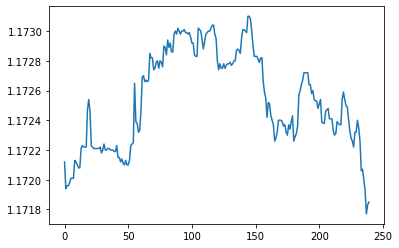

In [87]:
######################################################## EXPLORATORY DATA ANALYSIS ########################################################
import matplotlib.pyplot as plt
iIndex = 1

plt.plot(X[iIndex])
plt.show()

(array([ 915., 1869., 2136., 5833., 8347., 7491., 9865., 4809., 1847.,
         470.]),
 array([1.16085 , 1.163957, 1.167064, 1.170171, 1.173278, 1.176385,
        1.179492, 1.182599, 1.185706, 1.188813, 1.19192 ]),
 <BarContainer object of 10 artists>)

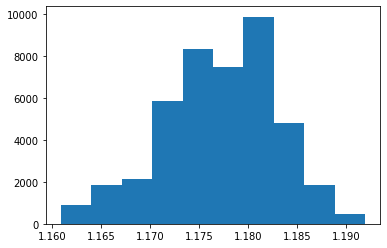

In [ ]:
plt.hist(Y[:, :,0])

In [117]:
######################################################## MODEL ########################################################
import tensorflow as tf


class TransformerEncoder(tf.Module):
    def __init__(self, key_dim, num_heads, ff_dim, dropout):
        super(TransformerEncoder, self).__init__()
        self.key_dim = key_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        
        
    def __call__(self, x):
        # Normalization and Attention
        y = tf.keras.layers.LayerNormalization(epsilon =1e-6)(x)
        y = tf.keras.layers.MultiHeadAttention(
            key_dim=self.key_dim,
            num_heads = self.num_heads,
            dropout = self.dropout
        )(y,y) # self attention
        y = tf.keras.layers.Dropout(self.dropout)(y)
        res = y + x
        
        
        # Feed Forward Part
        y = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(res)
        y = tf.keras.layers.Conv1D(filters = self.ff_dim, kernel_size=  1, activation = 'relu')(y)
        y = tf.keras.layers.Dropout(self.dropout)(y)
        y = tf.keras.layers.Conv1D(filters=x.shape[-1], kernel_size = 1)(y)
        
        return y + res
        
        
    
class DisERT(tf.Module):
    def __init__(
        self,
        p_bin_boundaries,
        p_size_of_chunk,
        p_attention_key_dims,
        p_attention_nr_of_heads,
        p_encoder_dense_dims,
        p_dropout_rate,
        p_nr_of_encoder_blocks
    ):
        super(DisERT, self).__init__()
        
        aLayers = [
            tf.keras.layers.Reshape((-1, p_size_of_chunk)),
            tf.keras.layers.TimeDistributed(
                tf.keras.layers.Discretization(
                    bin_boundaries = p_bin_boundaries,
                    output_mode = 'count'
                )
            ),
            tf.keras.layers.Rescaling(scale = 1/p_size_of_chunk) # could be applied softmax as well.
        ]
        
        self.InputBinDistributionByChunks = tf.keras.Sequential(aLayers)
        
        
        self.Encoders = []
        for i in range(p_nr_of_encoder_blocks):
            self.Encoders.append(
                TransformerEncoder(p_attention_key_dims, p_attention_nr_of_heads, p_encoder_dense_dims, p_dropout_rate)
            )
            
            
    def __call__(self, x):
        xBinDistByChunks = self.InputBinDistributionByChunks(x)

        xEncoder = xBinDistByChunks


        for oEncoder in self.Encoders:
            xEncoder= oEncoder(xEncoder)


        return xBinDistByChunks, xEncoder
        
        

        
# Limits of BIN_BOUNDARIES should be calculated dynamically. Otherwise, it creates too sparse input dataset which may not be good for learning.
# Idea #1: to use daily minimum and maximum...
# Idea #2: Keep it sparse however, apply FFT to get differences...
# Idea #3: We can have several more BIN_BOUNDARIES variables...
# I think, Idea #1 is more secure... However, we need to build higher scale logic...
# Higher scale can be part of any X_TIME feature.
# However, we must keep, NR_OF_BOUNDARIES constant

NR_OF_BOUNDARIES = 10
BIN_BOUNDARIES = np.linspace(1.170, 1.185, NR_OF_BOUNDARIES) 
SIZE_OF_CHUNK = 30
ATTENTION_KEY_DIMS = 64
ATTENTION_NR_OF_HEADS = 6
ENCODER_DENSE_DIMS = 32
DROPOUT_RATE = 0
NR_OF_ENCODER_BLOCKS = 3
        
oDisERT = DisERT(
        p_bin_boundaries = BIN_BOUNDARIES,
        p_size_of_chunk = SIZE_OF_CHUNK,
        p_attention_key_dims = ATTENTION_KEY_DIMS,
        p_attention_nr_of_heads = ATTENTION_NR_OF_HEADS,
        p_encoder_dense_dims = ENCODER_DENSE_DIMS,
        p_dropout_rate = DROPOUT_RATE,
        p_nr_of_encoder_blocks = NR_OF_ENCODER_BLOCKS
)

xBinDistByChunks, xEncoder = oDisERT(X)
# oModel = tf.keras.Model(inputs=[oModel.input], outputs=[oModel.output])



# oModel.compile(
#     loss = 'mean_squared_error',  
#     optimizer = 'adam', 
#     metrics = 'mae')

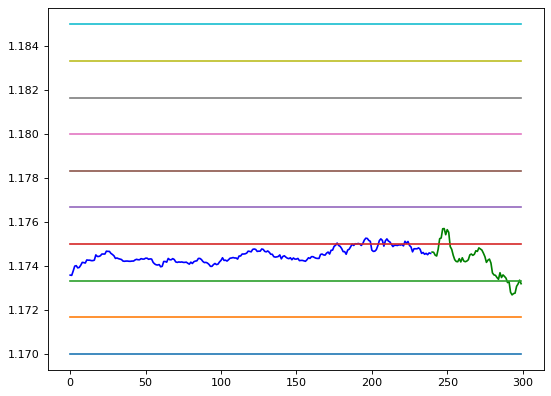

In [144]:
iIndex = 350
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(X.shape[1]), X[iIndex], color=  'blue')
plt.plot(np.arange(X.shape[1], X.shape[1] + Y.shape[1]), Y[iIndex], color=  'green')

for i in BIN_BOUNDARIES:
    plt.plot(np.ones(X.shape[1] + Y.shape[1]) * i)

In [ ]:
iTrainSize=  1000
iTestSize = 50

X_train = X[0:iTrainSize].reshape(-1, 240)
X_TIME_train = X_TIME[0:iTrainSize]
Y_train = Y[0:iTrainSize].reshape(-1, 60)

X_test = X[iTrainSize+1:iTrainSize+1+iTestSize].reshape(-1, 240)
X_TIME_test = X_TIME[iTrainSize+1:iTrainSize+1+iTestSize]
Y_test = Y[iTrainSize+1:iTrainSize+1+iTestSize].reshape(-1, 60)

# Fit model
oModel.fit(
    [X_train, X_TIME_train], 
    Y_train, 
    epochs= 10**2, 
    batch_size=2**8, 
    verbose=1
)

In [ ]:
ixToCheck = 10
plt.plot(oModel.predict([X_test, X_TIME_test])[ixToCheck], color = 'red',label = 'prediction')
plt.plot(Y_test[ixToCheck], color = 'green', label = 'actual' )
plt.legend()
plt.show()